In [1]:
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

from utils import *

In [2]:
df = pd.read_csv('../data/modified_small_imputed.csv')

In [3]:
df['event'] = df['outcome_pregnant']
df['duration'] = df['n_cycles_trying']

In [4]:
numerical_vars = [
    #"age", "dedication", "intercourse_frequency"
]

categorical_vars = {
    'age_group':'30-35',
    'bmi_group':'normal',
    'been_pregnant_before_binary':False,
    'average_cycle_length_group':'21-35',
    'regular_cycle':True,
    'university_education':False,
    'regular_sleep':True,
    'intercourse_frequency_group':'medium',
    'dedication_group':'medium'
}


In [5]:
X_df = prepare_cox_model_matrix(df, categorical_baselines=categorical_vars,
                             numerical_features=numerical_vars)

In [6]:
X_df.shape

(1995, 15)

In [7]:
df.shape

(1995, 13)

In [8]:
1995-1244

751

In [9]:
# Fit Cox model
cph = CoxPHFitter()
cph.fit(X_df, duration_col='duration', event_col='event')

# Display model summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1995 total observations, 847 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1995
number of events observed = 1148
   partial log-likelihood = -7772.50
         time fit was run = 2025-06-15 14:21:01 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
age_group_35-44                       -0.48      0.62      0.09           -0.65           -0.31                0.52                0.74
age_group_19-29                        0.10      1.11      0.07           -0.04            0.24                0.96                1.27
bmi_group_overweight                  -0.09      0.91      0.07           -0.23            0.04                0.80                1.04
bmi_group_underweight                 -0.29      0.75      0.15           -0.59            0.01                0.55                1.01
been_pregnant_before_binary_True       0.25      1.28      0.07            0.11            0.38                1.11                1.47
average_cycle_length_group_<21 OR >35  0.18      1.20      0.11           -0.04            0.41                0.96                1.50
regular_cycle_False                   -0.17      0.84      0.09           -0.35            0.01                0.70                1.01
university_education_True              0.08      1.08      0.08           -0.08            0.23                0.93                1.26
regular_sleep_False                   -0.01      0.99      0.07           -0.14            0.12                0.87                1.13
intercourse_frequency_group_high       0.54      1.72      0.07            0.41            0.68                1.51                1.96
intercourse_frequency_group_low       -0.18      0.83      0.10           -0.37            0.00                0.69                1.00
dedication_group_low                  -0.39      0.67      0.10           -0.59           -0.20                0.56                0.82
dedication_group_high                  0.62      1.86      0.07            0.49            0.75                1.63                2.12

                                       cmp to     z      p  -log2(p)
covariate                                                           
age_group_35-44                          0.00 -5.42 <0.005     23.98
age_group_19-29                          0.00  1.42   0.16      2.67
bmi_group_overweight                     0.00 -1.39   0.17      2.59
bmi_group_underweight                    0.00 -1.92   0.05      4.19
been_pregnant_before_binary_True         0.00  3.45 <0.005     10.80
average_cycle_length_group_<21 OR >35    0.00  1.62   0.11      3.24
regular_cycle_False                      0.00 -1.85   0.06      3.97
university_education_True                0.00  0.97   0.33      1.60
regular_sleep_False                      0.00 -0.13   0.90      0.16
intercourse_frequency_group_high         0.00  8.00 <0.005     49.49
intercourse_frequency_group_low          0.00 -1.92   0.06      4.18
dedication_group_low                     0.00 -4.01 <0.005     13.98
dedication_group_high                    0.00  9.22 <0.005     64.88
---
Concordance = 0.69
Partial AIC = 15571.00
log-likelihood ratio test = 364.24 on 13 df
-log2(p) of ll-ratio test = 229.57

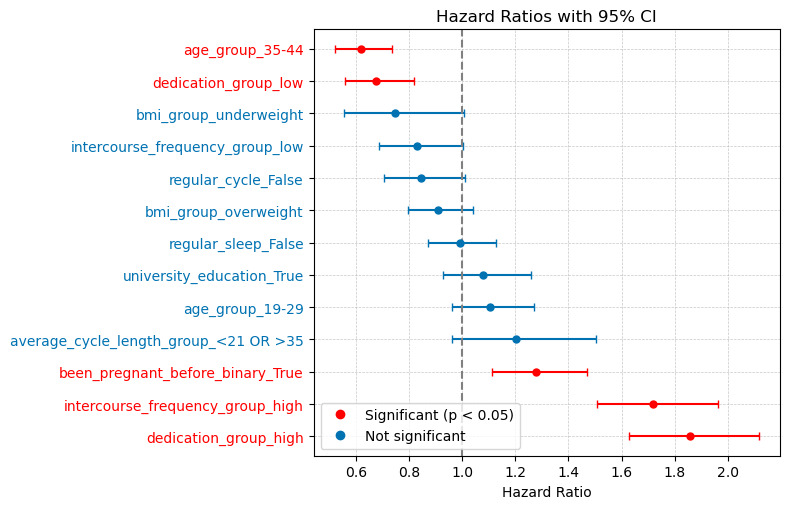

In [10]:
plot_hazard_ratios(cph, output_folder="../plots", plot_name="cox_hr_plot")


In [11]:
def interpret_hr(hazard_ratio, baseline_prob, n_cycles=13):
    """
    Interpret a hazard ratio in terms of:
    - Adjusted per-cycle probability (approximate)
    - Cumulative probability within n cycles
    - Median time to pregnancy (in cycles)

    Parameters:
        hazard_ratio (float): HR from Cox model
        baseline_prob (float): baseline per-cycle pregnancy probability
        n_cycles (int): number of cycles to compute cumulative probability

    Returns:
        dict with adjusted values
    """
    # Adjusted per-cycle probability based on hazard ratio
    p0 = baseline_prob
    hr = hazard_ratio
    p1 = 1 - (1 - p0) ** hr  # Approximate formula

    # Probability of pregnancy within n cycles
    cumulative_prob = 1 - (1 - p1) ** n_cycles

    # Median time to pregnancy
    if p1 == 1.0:
        median_ttp = 1
    else:
        median_ttp = np.log(0.5) / np.log(1 - p1)

    return {
        "adjusted_per_cycle_probability": p1,
        "cumulative_probability_within_n_cycles": cumulative_prob,
        "median_time_to_pregnancy": median_ttp
    }

In [12]:
subset = df[df['average_cycle_length_group'] == '<21']
print(f"Total in <21 group: {len(subset)}")
print(subset['event'].value_counts())

Total in <21 group: 0
Series([], Name: count, dtype: int64)
